In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict
from matplotlib.colors import LogNorm

def load_obs_data(year,datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'):
    """ Returns a dataframe containing nutrient bottle data for a given year merged with station data
    """
    dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))
    dfBot=pickle.load(open(os.path.join(datadir,f'Bottles_{str(year)}.p'),'rb'))
    df=pd.merge(left=dfSta,right=dfBot,how='right',
             left_on='Station',right_on='Station')
    try:
        len(df.loc[pd.isnull(df['Latitude'])]) == 0
    except:
        pass
        print('Warning!, Stations found without Latitude or Longitude value!')
    try:
        len(df) == len(dfBot)
    except:
        pass
        print(f'Warning!, Merge completed incorrectly. length of bottle data = {len(dfBot)} length of merged data = {len(df)}')
    # where no time is provided, set time to midday Pacific time = ~ 20:00 UTC
    df['UTCDateTime']=[iiD+dt.timedelta(hours=20) if pd.isnull(iiU) \
                    else iiU for iiU,iiD in \
                    zip(df['UTCDateTime'],df['Date'])]
    df.rename(columns={'UTCDateTime':'dtUTC','Latitude':'Lat','Longitude':'Lon'},inplace=True)
    df['Z']=-1*df['Z']
    df.head()
    df['NO23']=df['NO3(uM)D']+df['NO2(uM)D'] # the model does not distinguish between NO2 and NO3
    df['Amm']=df['NH4(uM)D']
    df['Si']=df['SiOH4(uM)D']
    df['Year']=[ii.year for ii in df['dtUTC']]
    df['YD']=et.datetimeToYD(df['dtUTC'])
    return(df)
    
def load_CTD_data(year,datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'):
    """ Returns a dataframe containing CTD data for a given year merged with station data
    """
    dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))
    dfCTD0=pickle.load(open(os.path.join(datadir,f'Casts_{str(year)}.p'),'rb'))
    dfCTD=pd.merge(left=dfSta,right=dfCTD0,how='right',
             left_on='Station',right_on='Station')
    try:
        dfCTD.groupby(['Station','Year','YD','Z']).count()==[1]
    except:
        pass
        print('Only one cast per CTD station per day')
    # where no time is provided, set time to midday Pacific time = ~ 20:00 UTC
    dfCTD['dtUTC']=[iiD+dt.timedelta(hours=20) for iiD in dfCTD['Date']] #Does this mean it also has that flaw where we are not sure when the data was collected?
    dfCTD.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
    dfCTD['Z']=-1*dfCTD['Z']
    # Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
    # Salinity (psu) and Temperature (deg C):
    press=gsw.p_from_z(-1*dfCTD['Z'],dfCTD['Lat'])
    dfCTD['SA']=gsw.SA_from_SP(dfCTD['Salinity'],press,
                           dfCTD['Lon'],dfCTD['Lat'])
    dfCTD['CT']=gsw.CT_from_t(dfCTD['SA'],dfCTD['Temperature'],press)
    dfCTD['Year']=[ii.year for ii in dfCTD['dtUTC']]
    dfCTD['YD']=et.datetimeToYD(dfCTD['dtUTC'])
    return(dfCTD)

In [16]:
df=load_obs_data(2015)

In [3]:
dfCTD=load_CTD_data(2015)

Only one cast per CTD station per day


In [38]:
obsvar='Si'
modvar='mod_silicon'
start_date=dt.datetime(2015,1,1)
end_date=dt.datetime(2015,12,31)
time0=et._deframe(df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),['dtUTC']])
obs0=et._deframe(df[obsvar])

In [47]:
sepvar='Z'
obs0=et._deframe(df.loc[(df[obsvar]==df[obsvar])&(df[sepvar]==df[sepvar])&(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),['dtUTC']])
obs0[1:8]
#time0=et._deframe(df.loc[(df[obsvar]==df[obsvar])&(df[modvar]==df[modvar])&(df[sepvar]==df[sepvar]),(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date)])

array(['2015-01-20T19:14:00.000000000', '2015-01-20T19:14:00.000000000',
       '2015-02-12T18:04:00.000000000', '2015-02-12T18:04:00.000000000',
       '2015-02-12T18:04:00.000000000', '2015-03-04T21:26:00.000000000',
       '2015-03-04T21:26:00.000000000'], dtype='datetime64[ns]')

In [4]:
x=range(2007,2020)

In [5]:
for i in x:
    print(i)

2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [7]:
data_list=[7,8,9,10]

new_list = [data_list[i:i+2] for i in range(0, len(data_list), 2)]

In [13]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

In [14]:
math.ceil(len(regions)/2)

3

In [1]:
l1=[1,2,3]
l2=[1,2,3]
l3=[1,2,3]

In [3]:
x,c,d=zip(l1,l2,l3)
for i,f,j in x,c,d:
    print(i)
    print(j)
    print(f)

1
1
1
2
2
2
3
3
3


In [11]:
x=[]
x.append(l1)
x.append(l2)
flattened = [val for sublist in x for val in sublist]

In [12]:
flattened

[1, 2, 3, 1, 2, 3]

In [9]:
dt.datetime(2015,1,1,21,3)

datetime.datetime(2015, 1, 1, 21, 3)

[array([65.28076467]),
 4,
 array([1.38446749, 1.32119158, 0.50443316, 0.28853036]),
 1.1324274851176597e-14]

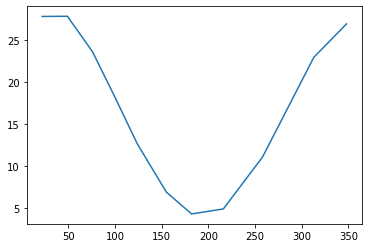

In [79]:
df=df.sort_values(by='dtUTC')
obs0=et._deframe(df.loc[(df['Basin'] == 'South Basin'),['NO23']])
timepy=df[df['Basin'] == 'South Basin'].dtUTC.dt.to_pydatetime()
time0=et._deframe(timepy)
yd=[]
for i in time0:
    yd.append((i - dt.datetime(i.year, 1, 1)).days + 1)
coefs = P.polyfit(yd,obs0,4)
ffit = P.polyval(yd, coefs)
plt.plot(yd, ffit)

In [82]:
def trendline (ax,df,region,obsvar,modvar):
    df=df.sort_values(by='dtUTC')
    obs0=et._deframe(df.loc[(df['Basin'] == region),[obsvar]])
    mod0=et._deframe(df.loc[(df['Basin'] == region),[modvar]])
    timepy=df[df['Basin'] == 'South Basin'].dtUTC.dt.to_pydatetime()
    time0=et._deframe(timepy)
    yd=[]
    for i in time0:
        yd.append((i - dt.datetime(i.year, 1, 1)).days + 1)
    coefso = poly.polyfit(yd,obs0,4)
    ffito = poly.polyval(yd, coefso)
    coefsm = poly.polyfit(yd,mod0,4)
    ffitm = poly.polyval(yd, coefsm)
    ax.plot(time0, ffito, color='blue')
    ax.plot(time0, ffitm, color='green')

In [9]:
sepvar='Z'

x=et._deframe(df.loc[(df[sepvar]==df[sepvar]),[sepvar]])

In [10]:
sep0=np.array([1,1,1,2,2,2,7,7,7])
sepvals=[4,9]
ii=0
iii=np.logical_and(sep0<sepvals[ii],sep0>=sepvals[ii-1])

In [12]:
np.sum(iii)

0

In [7]:
df = pd.DataFrame([[np.nan, 2, np.nan, 0], [3, 4, np.nan, 1],
...                    [np.nan, np.nan, np.nan, 5]],
...                   columns=list('ABCD'))

In [8]:
df

,A,B,C,D
0,NaN,2.0,NaN,0
1,3.0,4.0,NaN,1
2,NaN,NaN,NaN,5


In [11]:
df.dropna(axis=0,subset=['D'])

,A,B,C,D
0,NaN,2.0,NaN,0
1,3.0,4.0,NaN,1
2,NaN,NaN,NaN,5


In [12]:
np.sort([1,5,3,7])

array([1, 3, 5, 7])

In [14]:
np.array([1,2,3,4])

array([1, 2, 3, 4])

In [27]:
df=df.sort_values(by='dtUTC')
df=df.dropna(axis=0,subset=['NO23','dtUTC'])
dfg=df.groupby(by='dtUTC')
df_mean=dfg.mean()
df_mean['decimal_date']=df_mean.index.year+ (df_mean.index.dayofyear -1 + df_mean.index.hour/24 + df_mean.index.minute/1440 + df_mean.index.second/86400)/365


In [29]:
df_mean.decimal_date[0]

2015.0350761035008